In [1]:
import sys
import torch
import os
from os import makedirs
from argparse import ArgumentParser
from argparse import Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams, get_combined_args
import numpy as np
from scene import Scene, GaussianModel
from utils.general_utils import safe_state
import open3d as o3d
from utils.loss_utils import l1_loss, ssim
from utils.image_utils import psnr
from random import randint
from gaussian_renderer import render, network_gui
import matplotlib.pyplot as plt
from utils.graphics_utils import BasicPointCloud
from tqdm import tqdm
import cv2
from train_utils import showTensorDepthImage, showTensorImage, prepare_output_and_logger, training_report, showGSRender, loadPLY, saveTensorAsPLY, renderGS, saveCurrentRender

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
np.set_printoptions(suppress=True)
# Set the precision of elements to 2 decimal places
torch.set_printoptions(precision=2)

# Limit the number of elements shown to 5
torch.set_printoptions(threshold=5)
torch.set_printoptions(sci_mode=False)

In [3]:
def showRasterizedImageComp(image1, image2):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the first image on the left subplot
    axes[0].imshow(image1)
    axes[0].set_title('Current PC Image')

    # Display the second image on the right subplot
    axes[1].imshow(image2)
    axes[1].set_title('Global PC Raster')

    # Hide the axes ticks
    for ax in axes:
        ax.axis('off')

    # Show the plot
    plt.show()    

def showRasterizedImage(u,v, colors, rgb_height, rgb_width):
    # print(u.shape, v.shape, colors.shape)
    u = u.cpu().detach().numpy()
    v = v.cpu().detach().numpy()
    colors = colors.cpu().detach().numpy()

    assert len(u) == len(v) == len(colors)
    image_size = (rgb_height, rgb_width, 3)
    raster = np.zeros(image_size, dtype=np.float32)

    # print(np.shape(u), np.shape(v), np.shape(colors), np.shape(raster))

    raster[v, u] = colors
    # Clip values to ensure they are in the valid range [0, 1]
    image = np.clip(raster, 0, 1)
    plt.imshow(raster)
    plt.show()
    return image

def showFilterMaskImage(indices_not_in_global, rgb_height, rgb_width):
    u = indices_not_in_global[:,0]
    v = indices_not_in_global[:,1]
    u = u.cpu().detach().numpy()
    v = v.cpu().detach().numpy()
    assert len(u) == len(v)
    image_size = (rgb_height, rgb_width, 3)
    raster = np.zeros(image_size, dtype=np.float32)
    raster[v, u] = 1
    plt.imshow(raster)
    plt.show()

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [5]:
def renderGSwithStats(viewpoint_cam, gaussians, pipeline):
    with torch.no_grad():
        print(viewpoint_cam.colmap_id)
        print(viewpoint_cam.R)
        print(viewpoint_cam.T)
        print(viewpoint_cam.camera_center)
        print(viewpoint_cam.image_width, viewpoint_cam.image_height)
        print('W2C:',viewpoint_cam.world_view_transform.transpose(0,1))
        print('Projection',viewpoint_cam.projection_matrix.transpose(0,1))
        print('FProjection:',viewpoint_cam.full_proj_transform.transpose(0,1))

        # Render
        bg = torch.ones((3), device="cuda")
        render_pkg = render(viewpoint_cam, gaussians, pipeline, bg)
        image, viewspace_point_tensor, visibility_filter, radii, raster_depth_map = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"], render_pkg["raster_depth"]
        # image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]
        showGSRender(image)

        print("Visibility Filter: ", visibility_filter.shape)
        print("Radii: ", radii.shape)
        print("Viewsapce Points: ", viewspace_point_tensor.shape)
    
def getGaussianDepthMap(viewpoint_cam, gaussians, pipeline):
    image, viewspace_point_tensor, visibility_filter, radii, raster_depth_map, visibility_map = renderGS(viewpoint_cam, gaussians, pipeline)
    return raster_depth_map, visibility_map

In [6]:
# Setup Command line Arg
sys.argv = ["train.py", 
            "-s", "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\SyntheticV1",
            "-r" ,"2",
            "-m" , "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\output\\SyntheticV1"]

parser = ArgumentParser(description='Progressice Gaussian Splatting')
model = ModelParams(parser)
pipeline = PipelineParams(parser)
op = OptimizationParams(parser)

# parser.add_argument('--ip', type=str, default="127.0.0.1")
# parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
# parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--save_iterations", nargs="+", type=int, default=[10, 30, 60])
parser.add_argument("--test_iterations", nargs="+", type=int, default=[])
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[15, 30, 60])
parser.add_argument("--start_checkpoint", type=str, default = None)

args = parser.parse_args(sys.argv[1:])

# Initialize system state (RNG)
# safe_state(args.quiet)

dataset, iteration, pipeline = model.extract(args), op.extract(args), pipeline.extract(args)

testing_iterations, saving_iterations, checkpoint_iterations, checkpoint, debug_from = args.test_iterations, args.save_iterations, args.checkpoint_iterations, args.start_checkpoint, args.debug_from

In [7]:
with torch.no_grad():
    # Initialize Gaussians with Zero Tensor
    gaussians = GaussianModel(dataset.sh_degree)
    # Load Actual Gaussians, Camera from PCD
    scene = Scene(dataset, gaussians, shuffle=False)

Loading RGBD Scene
Loading Training Cameras
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution to:  (960, 540)
Rescaled resolution 

In [8]:
# Get the viewpoint stack
viewpoint_stack = None
opt = op.extract(args)
if not viewpoint_stack:
    viewpoint_stack = scene.getTrainCameras().copy()
    
# viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

In [9]:
# saveCurrentRender(viewpoint_stack[2], gaussians, pipeline, scene.model_path, 0)

0000
[[-1.         -0.          0.00000009]
 [-0.00000004 -0.86602497 -0.5       ]
 [ 0.00000008 -0.5         0.86602497]]
[ 0.49999979  2.01602507 -1.49185753]
tensor([0.50, 1.00, 2.30], device='cuda:0')
960 540
W2C: tensor([[    -1.00,     -0.00,      0.00,      0.50],
        [    -0.00,     -0.87,     -0.50,      2.02],
        [     0.00,     -0.50,      0.87,     -1.49],
        [     0.00,      0.00,      0.00,      1.00]], device='cuda:0')
Projection tensor([[ 1.00,  0.00,  0.00,  0.00],
        [ 0.00,  1.78,  0.00,  0.00],
        [ 0.00,  0.00,  1.00, -0.01],
        [ 0.00,  0.00,  1.00,  0.00]], device='cuda:0')
FProjection: tensor([[    -1.00,     -0.00,      0.00,      0.50],
        [    -0.00,     -1.54,     -0.89,      3.58],
        [     0.00,     -0.50,      0.87,     -1.50],
        [     0.00,     -0.50,      0.87,     -1.49]], device='cuda:0')


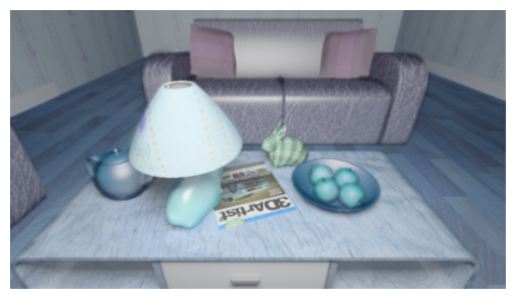

Visibility Filter:  torch.Size([518400])
Radii:  torch.Size([518400])
Viewsapce Points:  torch.Size([518400, 3])


In [10]:
# Redner the first viewpoint
renderGSwithStats(viewpoint_stack[0], gaussians, pipeline)

In [ ]:
raster_depth_map, visibility_map = getGaussianDepthMap(viewpoint_stack[0], gaussians, pipeline)

# Account for 0 depth
default_depth = 999.0
raster_depth_map = raster_depth_map #* ~(raster_depth_map==default_depth)
# print(raster_depth_map.min(), raster_depth_map.max())
# showTensorDepthImage(raster_depth_map)

image_array = raster_depth_map.cpu().numpy()
plt.imshow(image_array, cmap='gray')
plt.colorbar()
plt.show()


In [ ]:
image, viewspace_point_tensor, visibility_filter, radii, raster_depth_map, visibility_map = renderGS(viewpoint_stack[0], gaussians, pipeline)

In [ ]:
showTensorDepthImage(raster_depth_map)

In [ ]:
raster_depth_map

In [ ]:
torch.abs(raster_depth_map - viewpoint_stack[0].original_depth).sum()

In [ ]:
image_array = visibility_map.cpu().numpy()
plt.imshow(image_array < 0.5, cmap='Greys')
plt.colorbar()
plt.show()

In [ ]:
# Visualize the depth map
# Default_Depth = 1000000 # raster_depth_map.max()
# mask = raster_depth_map == Default_Depth
# # Filter out the default depth
# raster_depth_map[mask] = 0
# # Visualize the depth map
# showTensorDepthImage(raster_depth_map)

In [ ]:
ply_path = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\SyntheticV1\\ply"

ply_files = os.listdir(ply_path)

# 2D Rasterization
def rasterizePoints_Perspective(points, colors,  viewpoint_cam, sub_pixel_level=1):
       # Get Projection Matrix
       P = viewpoint_cam.full_proj_transform

       # Project points using projection matrix P in torch cuda and get result in NDC
       points_homogeneous = torch.cat((points, torch.ones(points.shape[0], 1, device=points.device)), dim=1)
       
       projected_points_homogeneous = torch.matmul(points_homogeneous, P.t()) # Clip space coordinates


       print(points_homogeneous.shape, projected_points_homogeneous.shape)
       # print('Clip Space: ', projected_points_homogeneous.shape, projected_points_homogeneous.min(), projected_points_homogeneous.max())

       # # Filter points outside clip space
       # mask = (projected_points_homogeneous[:, 0] >= -1) & (projected_points_homogeneous[:, 0] < 1) & \
       #        (projected_points_homogeneous[:, 1] >= -1) & (projected_points_homogeneous[:, 1] < 1 ) # & \
              # (projected_points_homogeneous[:, 2] >= -1) & (projected_points_homogeneous[:, 2] < 1) // Removes points closer to camera so not included
       # projected_points_homogeneous = projected_points_homogeneous[mask]

       # Clip Space / Homogenous to NDC
       assert projected_points_homogeneous.shape[1] == 4
       # Extract x, y, z, w from the tensor
       x, y, z, w = projected_points_homogeneous[:, 0], projected_points_homogeneous[:, 1], projected_points_homogeneous[:, 2], projected_points_homogeneous[:, 3]
       x_ndc = x / w
       y_ndc = y / w
       z_ndc = z / w
       projected_points_NDC = torch.stack((x_ndc, y_ndc, z_ndc), dim=1)

       # print('NDC: ', projected_points_NDC.shape, projected_points_NDC.min(), projected_points_NDC.max())

       # NDC to Image Space [-1,1] to [0,1]
       projected_points_IS = (projected_points_NDC + 1) / 2

       # Filter points outside image space
       mask = (projected_points_IS[:, 0] >= 0) & (projected_points_IS[:, 0] < 1) & \
              (projected_points_IS[:, 1] >= 0) & (projected_points_IS[:, 1] < 1 ) # & \
              # (projected_points_IS[:, 2] >= 0) & (projected_points_IS[:, 2] < 1)
       # projected_points_IS = projected_points_IS[mask]
       # points_filtered = points[mask]
       # colors_filtered = colors[mask]

       # print(projected_points_IS.shape, projected_points_IS.min(), projected_points_IS.max())

       # Get image width and height
       img_width, img_height = viewpoint_cam.image_width, viewpoint_cam.image_height
       # Calculate effective pixel width and height based on the sub-pixel variable
       effective_pixel_width, effective_pixel_height = img_width // sub_pixel_level, img_height // sub_pixel_level
       # Get pixel coordinates
       pixel_coordinates = projected_points_IS[:,:2] * torch.tensor([effective_pixel_width, effective_pixel_height], device=points.device).float()
       pixel_indices = torch.floor(pixel_coordinates).to(torch.int)


       # Create an empty image for visualization
       img = torch.zeros((968, 1296, 3), dtype=torch.uint8, device=points.device)
       pixel_indices_long = pixel_indices.to(torch.long)
       pixel_indices_long = torch.clamp(pixel_indices_long, 0, img_width - 1)
       pixel_indices_long = torch.cat((pixel_indices_long[:, 1:], pixel_indices_long[:, :1]), dim=1)  # Swap x and y for indexing
       colors_uint8 = (colors * 255).to(torch.uint8)
       img[pixel_indices_long[:, 1], pixel_indices_long[:, 0]] = colors_uint8
       img_cpu = img.cpu().detach().numpy()
       plt.imshow(img_cpu.astype(int))  # Convert the image to int for display
       plt.show()

       # print(pixel_indices.shape, pixel_indices.min(), pixel_indices.max())
       # return points_filtered,colors_filtered,pixel_indices

In [ ]:
def getRGBDDepthMap(viewpoint_cam, points):
    intrinsics = viewpoint_cam.intrinsics
    c_x = intrinsics[0,2]
    c_y = intrinsics[1,2]
    f_x = intrinsics[0,0]
    f_y = intrinsics[1,1]
    W2C = viewpoint_cam.world_view_transform

    img_width, img_height = viewpoint_cam.image_width, viewpoint_cam.image_height

    full_proj_transform = viewpoint_cam.full_proj_transform

    # print('W2C:',W2C.transpose(0,1))
    # print('FP:',full_proj_transform.transpose(0,1))

    points_homogeneous = torch.cat((points, torch.ones(points.shape[0], 1, device=points.device)), dim=1)
    
    points_camera_homogeneous = torch.matmul(points_homogeneous, W2C) # Clip space coordinates
    Z = points_camera_homogeneous[:, 2]
    
    projected_points_homogeneous = torch.matmul(points_homogeneous, full_proj_transform)

    assert projected_points_homogeneous.shape[1] == 4
    # Extract x, y, z, w from the tensor
    x, y, z, w = projected_points_homogeneous[:, 0], projected_points_homogeneous[:, 1], projected_points_homogeneous[:, 2], projected_points_homogeneous[:, 3]
    x_ndc = x / w
    y_ndc = y / w
    z_ndc = z / w
    projected_points_NDC = torch.stack((x_ndc, y_ndc, z_ndc), dim=1)
    projected_points_IS = (projected_points_NDC + 1) / 2

    # print('NDC: ', projected_points_NDC.shape, projected_points_NDC.min(), projected_points_NDC.max())
    # print('IS: ', projected_points_IS.shape, projected_points_IS.min(), projected_points_IS.max())

    u = projected_points_IS[:,0] * img_width
    v = projected_points_IS[:,1] * img_height

    # print('UV: ', u.min(), u.max(), v.min(), v.max())

    # Filter points outside image space
    image_space_mask = (u >= 0) & (u < img_width) & (v >= 0) & (v < img_height )
    u = u[image_space_mask]
    v = v[image_space_mask]
    depth_filtered = Z[image_space_mask]

    try:
        raster_depth_map = torch.zeros((img_height, img_width), dtype=Z.dtype, device=points.device)

        # Create Indices
        u_long = u.to(torch.long)
        v_long = v.to(torch.long)

        # print(u_long, u_long.min(), u_long.max())

        # Store Point Positions
        raster_depth_map[v_long, u_long] = depth_filtered

    except Exception as e:
        print(f"Error: {e}")

    return raster_depth_map

def rasterizePoints(viewpoint_cam, points, colors=None, sub_pixel_level=1):
    intrinsics = viewpoint_cam.intrinsics
    c_x = intrinsics[0,2]
    c_y = intrinsics[1,2]
    f_x = intrinsics[0,0]
    f_y = intrinsics[1,1]
    W2C = viewpoint_cam.world_view_transform
    full_proj_transform = viewpoint_cam.full_proj_transform
    img_width, img_height = viewpoint_cam.image_width, viewpoint_cam.image_height

    # print('W2C:',W2C.transpose(0,1))
    # print('FP:',full_proj_transform.transpose(0,1))

    # Project points using projection matrix P in torch cuda and get result in NDC
    points_homogeneous = torch.cat((points, torch.ones(points.shape[0], 1, device=points.device)), dim=1)
    # print(points_homogeneous.shape, colors.shape, W2C)
    
    points_camera_homogeneous = torch.matmul(points_homogeneous, W2C) # Clip space coordinates
    projected_points_homogeneous = torch.matmul(points_homogeneous, full_proj_transform)

    assert projected_points_homogeneous. shape[1] == 4
    # Extract x, y, z, w from the tensor
    x, y, z, w = projected_points_homogeneous[:, 0], projected_points_homogeneous[:, 1], projected_points_homogeneous[:, 2], projected_points_homogeneous[:, 3]
    x_ndc = x / w
    y_ndc = y / w
    z_ndc = z / w
    projected_points_NDC = torch.stack((x_ndc, y_ndc, z_ndc), dim=1)
    projected_points_IS = (projected_points_NDC + 1) / 2

    u = projected_points_IS[:,0] * img_width
    v = projected_points_IS[:,1] * img_height
    Z = points_camera_homogeneous[:, 2]

    u = u.to(torch.int16)
    v = v.to(torch.int16)

    # Filter points outside image space
    image_space_mask = (u >= 0) & (u < img_width) & (v >= 0) & (v < img_height )
    u = u[image_space_mask]
    v = v[image_space_mask]
    points_filtered = points[image_space_mask]
    depth_filtered = Z[image_space_mask]
    # raster = showRasterizedImage(u,v, colors_filtered, img_height, img_width)

    try:
        # print(u.shape, v.shape, colors_filtered.shape)
        raster_color = torch.zeros((img_height, img_width, 3), dtype=torch.uint8 , device=points.device)
        raster_depth_map = torch.zeros((img_height, img_width), dtype=Z.dtype, device=points.device)

        IS_point_positions = torch.zeros((img_height, img_width, 3), dtype=torch.float16 , device=points.device)
        IS_point_colors = torch.zeros((img_height, img_width, 3), dtype=torch.float16 , device=points.device)

        # Create Indices
        u_long = u.to(torch.long)
        v_long = v.to(torch.long)
        # Store Point Positions
        raster_depth_map[v_long, u_long] = depth_filtered
        IS_point_positions[v_long, u_long] = points_filtered.to(torch.float16)
        
        # Store Point Colors
        if colors is not None:
            colors_filtered = colors[image_space_mask]
            raster_color[v_long, u_long] = (colors_filtered * 255).to(torch.uint8)
            IS_point_colors[v_long, u_long] = colors_filtered.to(torch.float16)
        else:
            colors_filtered = None


    except Exception as e:
        print(f"Error: {e}")

    # pixel_indices_long = torch.clamp(pixel_indices_long, 0, img_width - 1)
    # pixel_indices_long = torch.cat((pixel_indices_long[:, 1:], pixel_indices_long[:, :1]), dim=1)  # Swap x and y for indexing
    # colors_uint8 = (colors * 255).to(torch.uint8)
    # img[pixel_indices_long[:, 1], pixel_indices_long[:, 0]] = colors_uint8

    pixel_indices = torch.stack((u,v), dim=1)

    # print(pixel_indices.shape)

    # # print(pixel_indices.shape, pixel_indices.min(), pixel_indices.max())
    return points_filtered,colors_filtered,raster_depth_map, pixel_indices, raster_color, IS_point_positions, IS_point_colors

In [ ]:
pcd_points, pcd_colors = loadPLY(os.path.join(ply_path, ply_files[0]))
depth_map = getRGBDDepthMap(viewpoint_stack[0], pcd_points)
showTensorDepthImage(depth_map)

# pcd_points, pcd_colors = loadPLY(os.path.join(ply_path, ply_files[0]))
# filtered_points, filtered_colors, current_depth_map, indices, current_raster, raster_point_positions, raster_point_colors = rasterizePoints(viewpoint_stack[0], pcd_points, pcd_colors)
# showTensorDepthImage(current_depth_map)

In [ ]:
showTensorDepthImage(depth_map - raster_depth_map)

In [ ]:
# Add new points from PLY
sub_pixel_level = 1

global_points = None
global_colors = None

# Default Depth from GS
default_depth = 1000000.0
visibility_threshold = 0.5

# for i in tqdm(range(len(viewpoint_stack))):
for i in tqdm(range(0)):
    viewpoint_cam = viewpoint_stack[i]
    # Check if PLY file exists
    ply_file_name = viewpoint_cam.colmap_id + ".ply"
    filtered_ply_file_name = viewpoint_cam.colmap_id + "_filtered.ply"

    # print(ply_file_name)
    # if ply_file_name not in ply_files:
    #     continue

    ply_file_path = os.path.join(ply_path, ply_file_name)
    
    if os.path.exists(ply_file_path) == False:
        continue

    print(ply_file_path)

    pcd_points, pcd_colors = loadPLY(ply_file_path)
    filtered_points, filtered_colors, current_depth_map, indices, current_raster, raster_point_positions, raster_point_colors = rasterizePoints(viewpoint_cam, pcd_points, pcd_colors)

    # showTensorImage(current_raster)
    # print('Indices:', indices.shape, indices.min(), indices.max())

    # Load Initial Points
    if global_points is None:
        print("Initialized with points from first Frame")
        global_points = filtered_points
        global_colors = filtered_colors
    
    if i > 0:
        gaussian_points = scene.gaussians.get_xyz
        global_filtered_points, global_filtered_colors, global_depth_map , global_pixel_indices, global_raster, _ , _ = rasterizePoints(viewpoint_cam, gaussian_points)

        # global_depth_map, global_visibility_map = getGaussianDepthMap(viewpoint_cam, gaussians, pipeline)
        # Identify Free Pixels
        free_pixel_mask = (global_depth_map == 0) #(global_depth_map == default_depth) # (global_depth_map == 0) | 
        # free_pixel_mask = (global_visibility_map < visibility_threshold)
        
        # Identify Depth Pixels
        # closer_depth_mask = (current_depth_map > 0) & (current_depth_map < global_depth_map) & (torch.abs(global_depth_map - current_depth_map) > 0.1)
        mask = free_pixel_mask.int() # | closer_depth_mask
        # showTensorDepthImage(mask)
        # showTensorDepthImage(depth_near_mask.int())
        # showTensorDepthImage(mask.int())
        # showTensorImage(global_raster)
        # showTensorImage(current_raster)

        # Apply Mask to point positions that are black
        raster_point_positions_masked = raster_point_positions.view(-1, 3) * mask.view(-1, 1)
        current_raster_masked = raster_point_colors.view(-1, 3) * mask.view(-1, 1)

        # showTensorImage(current_raster_masked.view(current_raster.shape)*255)

        # # Find points which have all 0 values
        invalid_points_mask = torch.all(raster_point_positions_masked == 0, dim=1, keepdim=True)
        raster_point_positions_filtered = raster_point_positions_masked[~invalid_points_mask.view(-1)]
        current_raster_filtered = current_raster_masked[~invalid_points_mask.view(-1)]
        
        
        print(current_raster_filtered.shape, raster_point_positions_filtered.shape)

        if raster_point_positions_filtered.shape[0] == 0:
            continue
        # saveTensorAsPLY(raster_point_positions_filtered,current_raster_filtered, 'G'+filtered_ply_file_name)
        # saveTensorAsPLY(raster_point_positions_filtered,current_raster_filtered, filtered_ply_file_name)

        # print("Global Points:", global_points.shape, global_colors.shape)           
        # Append to global points
        global_points = torch.cat((global_points, raster_point_positions_filtered), dim=0)
        global_colors = torch.cat((global_colors, current_raster_filtered), dim=0)
        # print("Global Points Extended:", global_points.shape, global_colors.shape)
    
        # Initialize 3D Gaussians with new points and add to scene
        # scene.extendGaussians(BasicPointCloud(points=raster_point_positions_filtered.cpu().numpy(), colors=current_raster_filtered.cpu().numpy(), normals=None))

# saveTensorAsPLY(global_points,global_colors, "Global.ply")

In [ ]:
# # Visualize Global Mask
# global_black_mask = torch.all(global_raster == 0, dim=2, keepdim=True)
# # Apply Mask to point positions that are black
# raster_point_positions_masked = raster_point_positions.view(-1, 3) * global_black_mask.view(-1, 1)
# current_raster_masked = current_raster.view(-1, 3) * global_black_mask.view(-1, 1)

# # Find points which have all 0 values
# invalid_points_mask = torch.all(raster_point_positions_masked == 0, dim=1, keepdim=True)

# raster_point_positions_filtered = raster_point_positions_masked[~invalid_points_mask.view(-1)]
# current_raster_filtered = current_raster_masked[~invalid_points_mask.view(-1)]

# print(raster_point_positions_masked.shape, current_raster_masked.shape)
# print(raster_point_positions_filtered.shape, current_raster_filtered.shape)

# showTensorImage(global_raster)
# showTensorImage(current_raster)
# showTensorImage(current_raster_masked.view(current_raster.shape))

In [ ]:
len(viewpoint_stack), len(ply_files)

In [ ]:
# Initialize Profiler
prof = torch.profiler.profile(
schedule=torch.profiler.schedule(wait=0, warmup=0, active=1, repeat=0),
on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/'),
record_shapes=True,
profile_memory=True,
with_stack=True,
activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],)

In [ ]:
# Progressive Fusion
# prof.start()

first_viewpoint = 0
tb_writer = prepare_output_and_logger(dataset)
# gaussians = GaussianModel(dataset.sh_degree)
# scene = Scene(dataset, gaussians, shuffle=False)
gaussians.training_setup(opt)

if checkpoint:
    (model_params, first_iter) = torch.load(checkpoint)
    gaussians.restore(model_params, opt)

ply_path = os.path.join(dataset.source_path, "ply")

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

iter_start = torch.cuda.Event(enable_timing = True)
iter_end = torch.cuda.Event(enable_timing = True)

ema_loss_for_log = 0.0

viewpoint_stack = scene.getTrainCameras().copy()
num_viewpoints = len(viewpoint_stack)
progress_bar = tqdm(range(first_viewpoint, num_viewpoints), desc="Training progress")
first_viewpoint += 1

# Scene is Already loaded with First Frame
frame_batch_size = 5
frame_step = 2
visibility_threshold = 0.5
batch_iter = 10

# Densification
density_every = 1

assert viewpoint_stack != None, "Viewpoint Stack is None"

for viewpoint_index in range(first_viewpoint, num_viewpoints, frame_step):
    # Fuse K frames into Global Field
    # Gaussian Densification / Fusion
    start_cam_index = viewpoint_index
    end_cam_index = min(num_viewpoints, viewpoint_index + frame_step)

    # print("Fusing Frames: ", list(range(start_cam_index, end_cam_index)))
    for K_i in range(start_cam_index, end_cam_index):
        viewpoint_cam = viewpoint_stack[K_i]
        ply_file_name = viewpoint_cam.colmap_id + ".ply"        

        ply_file_path = os.path.join(ply_path, ply_file_name)
        assert os.path.exists(ply_file_path), "PLY File does not exist"

        pcd_points, pcd_colors = loadPLY(ply_file_path)
        filtered_points, filtered_colors, current_depth_map, indices, current_raster, raster_point_positions, raster_point_colors = rasterizePoints(viewpoint_cam, pcd_points, pcd_colors)
        global_depth_map, global_visibility_map = getGaussianDepthMap(viewpoint_cam, gaussians, pipeline)
        
        # Identify Free Pixels
        free_pixel_mask = (global_visibility_map < visibility_threshold)
        mask = free_pixel_mask.int()

        # Apply Mask to point positions
        raster_point_positions_masked = raster_point_positions.view(-1, 3) * mask.view(-1, 1)
        current_raster_masked = raster_point_colors.view(-1, 3) * mask.view(-1, 1)

        # showTensorImage(current_raster_masked.view(current_raster.shape)*255)

        # Filter points which are at origin
        invalid_points_mask = torch.all(raster_point_positions_masked == 0, dim=1, keepdim=True)
        raster_point_positions_filtered = raster_point_positions_masked[~invalid_points_mask.view(-1)]
        current_raster_filtered = current_raster_masked[~invalid_points_mask.view(-1)]
        
        # Fuse points into global field
        # Initialize 3D Gaussians with new points and add to scene
        scene.extendGaussians(BasicPointCloud(points=raster_point_positions_filtered.cpu().numpy(), colors=current_raster_filtered.cpu().numpy(), normals=None))

    # Clear Memory
    current_raster_filtered = None
    raster_point_positions_filtered = None
    raster_point_positions_masked = None
    current_raster_masked = None
    raster_point_positions = None
    raster_point_colors = None
    current_raster = None
    # torch.cuda.empty_cache()

    # Optimize over K frames
    # Gaussian Optimization
    for iter in range(batch_iter):
        if start_cam_index > 0 and start_cam_index - 2 >= 0:
            start_cam_index -= 2
    
        for cam_index in range(start_cam_index, end_cam_index):
            # Pick the current Camera
            viewpoint_cam = viewpoint_stack[cam_index]
            
            # Render
            bg = torch.rand((3), device="cuda") if opt.random_background else background

            render_pkg = render(viewpoint_cam, gaussians, pipeline, bg)
            image, viewspace_point_tensor, visibility_filter, radii, depth_map  = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"], render_pkg["raster_depth"]

            # RGB Loss
            gt_image = viewpoint_cam.original_image.cuda()
            Ll1 = l1_loss(image, gt_image)
            loss = (1.0 - opt.lambda_dssim) * Ll1 + opt.lambda_dssim * (1.0 - ssim(image, gt_image))
            
            # Depth Loss
            invalid_depth_mask = (depth_map == 0)
            depth_error = torch.abs(depth_map - viewpoint_cam.original_depth.cuda())[invalid_depth_mask].sum()
            loss += depth_error

            loss.backward()

        # Post loss accumulation of K frames
        with torch.no_grad():
            # Update Gaussians
            gaussians.optimizer.step()
            gaussians.optimizer.zero_grad(set_to_none = True)

            # Progress bar
            ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
            progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})

    # Densify the Scene after each batch optimization
    # Keep track of max radii in image-space for pruning
    gaussians.max_radii2D[visibility_filter] = torch.max(gaussians.max_radii2D[visibility_filter], radii[visibility_filter])
    # print(viewspace_point_tensor.shape, visibility_filter.shape)
    gaussians.add_densification_stats(viewspace_point_tensor, visibility_filter)
    size_threshold = 20
    gaussians.densify_and_prune(opt.densify_grad_threshold, 0.005, scene.cameras_extent, size_threshold)
    
    # Post Fusion and Optimization of K frames
    with torch.no_grad(): 
        # Update Progress Bar
        progress_bar.update(frame_step)

        # Log and save
        if (end_cam_index-1 in checkpoint_iterations):
            print("\n[ITER {}] Saving Checkpoint".format(end_cam_index))
            torch.save((gaussians.capture(), end_cam_index), scene.model_path + "/chkpnt" + str(end_cam_index) + ".pth")

        if (end_cam_index-1 in saving_iterations):
            print("\n[ITER {}] Saving Gaussians".format(end_cam_index))
            scene.save(end_cam_index)
        
    # prof.step()

# Finished Training
# prof.stop()
progress_bar.close()
torch.cuda.empty_cache()


In [ ]:
scene.save(20)

In [ ]:
# import torch
# torch.profiler.tensorboard_trace("G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\log", ".", "tensorboard_log_directory")